In [40]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time 

from scipy.stats import norm

from itertools import product

In [61]:
EXPECT_PRECISION = 4

def expect_x(f, P):
    lists = [[-1, 1] for i in range(P)]
    xs = product(*lists)
    
    avg = 0.0
    for x in xs:
        x = np.array(x)
        avg += f(x) / (2 ** P)
    
    return avg

# returns \mu_S(f)
# runs in O(F * 2^P) time F runtime of F
def mu(f, P, S):
    return expect_x(lambda x: f(x) * np.prod(x[S]), P)

# calculate h^* for a given parity set S
def h(x, S, coefs = None):
    if coefs is None:
        coefs = [1] * len(S)
    
    acc = 0.0
    for idxs, coef in zip(S, coefs):
        acc += coef * np.prod(x[idxs])
    return acc

# return neuron value given x, theta
# calculates \E_G \lambda \sigma(\langle w_P, x\rangle + sG)
def neuron(x, theta):
    l = theta[0]
    s = theta[1]
    w = theta[2:]
    return norm.expect(lambda G: l * sp.special.expit(1.0+np.dot(x, w) + s * G), lb=-EXPECT_PRECISION, ub=EXPECT_PRECISION)

# calculate the neural network value given an empirical distribution over parameters
def net(x, rho):
    acc = 0.0
    k = len(rho)
    for theta in rho:
        acc += neuron(x, theta) / k
    return acc

# given empirical distribution, calculate \Psi(\theta, \rho)
def psi(theta, rho, y):
    P = len(theta) - 2
    
    U = -expect_x(lambda x: y(x) * neuron(x, theta), P)
    V = expect_x(lambda x: net(x,rho) * neuron(x, theta), P)
    return U + V

def grad_psi(thgeta, rho, y):
    
    pass

In [62]:
mu(lambda x: x[1], 4, [1])

1.0

In [63]:
neuron(np.array(1.0), np.array([1,1,1]))

0.8445027383986655

In [71]:
J = 100
P = 3

rho = np.zeros((J, P+2))
rho[:, 1] = 1
rho[:, 0] = np.random.uniform(-1, 1, size=J)
h_fn = lambda x: h(x, [1])

theta = rho[0]

start = time.time()
print(psi(theta, rho, h_fn))
# net(np.random.choice([-1,1], P), rho)
end = time.time()

print(f"{end-start:0.2f} seconds elapsed")

0.007983477581451785
1.62 seconds elapsed


In [69]:
net(np.random.choice([-1,1], P), rho)

0.045663914645334105

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import synthetic.models as syn_models
import synthetic.dataset as syn_data
import synthetic.func as syn_func
import json

import train

def running_avg(x, window_size = 10):
    x_new = torch.zeros_like(x)
    for i in range(x.shape[0]):
        if i < window_size:
            x_new[i] = x[:i+1].mean()
        else:
            x_new[i] = x_new[i-1] + (x[i] - x[i-window_size]) / window_size
    return x_new
    

In [8]:
directory = 'out/merged_staircase'
losses = torch.load(f'{directory}/losses.pt')
evals = torch.load(f'{directory}/evals.pt')

with open(f'{directory}/params.json', 'r') as f:
    params = json.load(f)

T = params['T']
batch_size = params['batch_size']
lr = params['lr']
losses.shape

torch.Size([1024000])

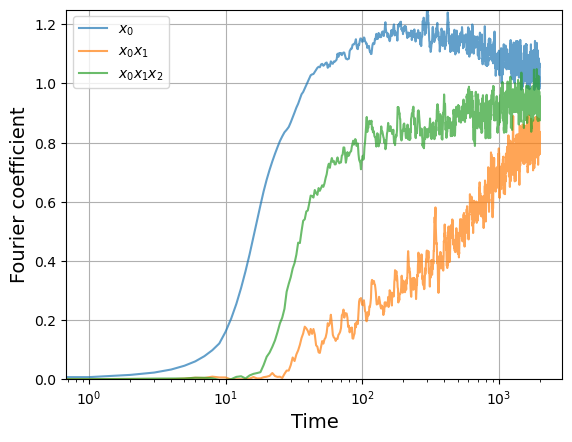

In [9]:
ts = evals['k'] * lr / batch_size
plt.ylabel('Fourier coefficient', fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.plot(ts, running_avg(evals['x[0]']), label=r"$x_0$", alpha=0.7)
plt.plot(ts, running_avg(evals['x[0, 1]']), label=r"$x_0x_1$", alpha = 0.7)
plt.plot(ts, running_avg(evals['x[0, 1, 2]']), label=r"$x_0x_1x_2$", alpha=0.7)
plt.grid()
plt.ylim((0, 1.25))
plt.xscale('log')
# plt.plot(ts, evals['test'])
plt.legend()
plt.savefig(f'{directory}/fourier_coefs.png')
plt.show()

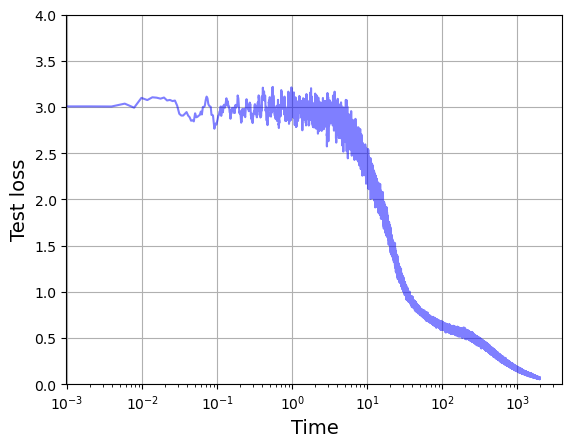

In [12]:
plt.ylabel('Test loss', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.xscale('log')

plt.ylim((0,4))

plt.grid()
ts = np.array(list(range(len(losses)))) * lr / batch_size
plt.plot(ts, running_avg(losses), 'b-', alpha = 0.5)
plt.savefig(f'{directory}/test_loss.png')
plt.show()